# Detección de matrículas (placas) mediante YOLOv3

**YOLO** se abrevia como **You Only Look Once** y tiene una excelente capacidad para detectar objetos y entidades mediante el uso de CNN (red neuronal convolucional). La red neuronal en YOLO utiliza pesos entrenados por el usuario a través de datos de entrenamiento anotados mediante el uso de cuadros delimitadores. Por lo tanto, YOLO toma una imagen como entrada, la pasa a través de una red neuronal y proporciona la salida en la imagen a través de cuadros delimitadores.

## Importando bibliotecas necesarias
es posible que su versión de Numpy no sea compatible con algunas librerias, por lo que será necesario desinstalarlo.


Si ha instalado la última vesión de anaconda no debería tener problemas

### NO EJECUTAR LAS SIGUIENTES LINEAS A MENOS QUE TENGA PROBLEMAS CON NUMPY

```
!pip uninstall numpy --yes
!pip install "numpy<1.17"
```

In [2]:
!pip uninstall numpy --yes

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4


You can safely remove it manually.


In [3]:
!pip install "numpy<1.17"

     ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
     - -------------------------------------- 0.3/5.1 MB 5.3 MB/s eta 0:00:01
     -------- ------------------------------- 1.2/5.1 MB 12.3 MB/s eta 0:00:01
     ---------------------- ----------------- 2.9/5.1 MB 20.8 MB/s eta 0:00:01
     -------------------------- ------------- 3.4/5.1 MB 18.2 MB/s eta 0:00:01
     ------------------------------------- -- 4.8/5.1 MB 20.7 MB/s eta 0:00:01
     ---------------------------------------- 5.1/5.1 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for numpy
Failed to build numpy


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [1]:
# dependencies
# NumPy versions below 1.17 may be incompatible with some other 
# packages, so you may need to replace your current version with 
# an earlier one in order to run this notebook as-is. 
# !pip uninstall numpy --yes
# !pip install "numpy<1.17"
#pip install ipython
#pip install matplotlib
#pip install opencv-python
#pip install argparse


from PIL import Image
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

### Si desea probar su propia imagen, simplemente agregue la ruta de la imagen en la variable input_path, agregue 'r' antes de la ruta para que sea tratada como una cadena sin formato.

#### Ejemplo: input_path = r'path_to_image_folder/image.jpg'

In [2]:
#ejemplo
input_path = r'test_dataset/images/1.jpg'

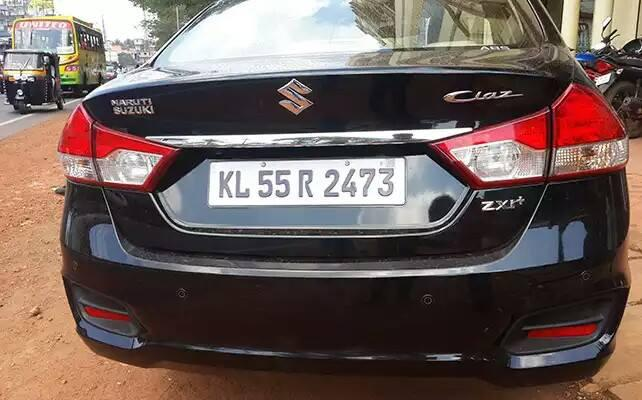

In [3]:
Image.open(input_path)

## Input Receiver

In [4]:
#simular una camara
cap = cv2.VideoCapture(input_path)


## Detección de placas con YOLO
### Inicializar los parámetros

In [5]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #ancho
inpHeight = 416     #alto

#### referencia nombres clases

se hace uso de las clases usadas en YOLO: LP-> License Plate

In [6]:
# Load names of classes
classesFile = "yolo_utils/classes.names";

In [7]:
# Append all different classes into the list 'classes'
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
classes    

['LP']

### Restaurar la red neuronal
#### Encuentre el archivo de configuración de YOLO aquí: yolo_utils
#### Es necesario cargar los pesos ya entrenados: lapi.weigths

Después de importar el archivo de configuración y pesos, configure el modelo usando ```cv2.dnn.readNetFromDarknet()```

In [8]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = r"yolo_utils/darknet-yolov3.cfg";
modelWeights = r"yolo_utils/lapi.weights";

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### Definir las funciones de posprocesamiento.

In [9]:
# Obtener los nombres de las capas de salida.
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

La siguiente función ``drawPred()`` dibuja un cuadro delimitador en una imagen cuando se pasan atributos como el nombre de la clase, la confianza, las coordenadas y la imagen misma.

In [10]:
# Dibuja el cuadro delimitador que se predice
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

La siguiente función `postprocess()` elimina los cuadros delimitadores con poca confianza 

In [11]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        #i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

### Detección de placas
El siguiente fragmento de código primero crea un blob 4D a partir de la imagen, establece la entrada a la red, ejecuta el paso directo para obtener la salida de las capas de salida y envía la imagen a la función ```postprocess()``` para eliminar los recuadros con baja confianza


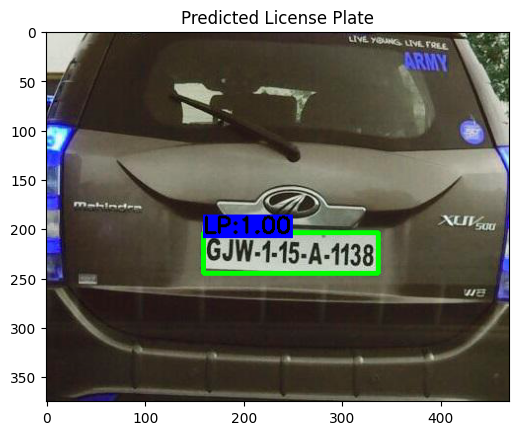

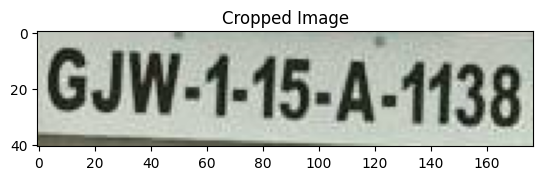

Finalizado !!!


In [12]:
#input_path = r'test_dataset/images/1.jpg'
input_path = r'test_dataset/images/2.jpg'
#input_path = r'test_dataset/images/3.jpg'

cap = cv2.VideoCapture(input_path)

while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Finalizado !!!")
        break

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted License Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.show()

## Segmentar caracteres
La segmentación de caracteres es una operación que busca descomponer una imagen de una secuencia de caracteres en subimágenes de símbolos individuales. Es uno de los procesos de decisión en un sistema de reconocimiento óptico de caracteres (OCR).

Esta fase contiene el uso de dos funciones: ```segment_characters()``` y ```find_contours()```.

In [13]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

En la función anterior, aplicaremos más procesamiento de imágenes para extraer los caracteres individuales de la matrícula. Los pasos a seguir serán:
- Encontrar todos los contornos en la imagen de entrada. La función cv2.findContours devuelve todos los contornos que encuentra en la imagen.
- Después de encontrar todos los contornos los consideramos uno por uno y calculamos la dimensión de su respectivo rectángulo delimitador. Ahora considere que el rectángulo delimitador es el rectángulo más pequeño posible que contiene el contorno. Todo lo que tenemos que hacer es ajustar algunos parámetros y filtrar el rectángulo requerido que contiene los caracteres requeridos. Para esto, realizaremos una comparación de dimensiones aceptando solo aquellos rectángulos que tengan:
   1. Ancho en el rango 0, (largo de la imagen)/(número de caracteres) y,
   2. Longitud en un rango de (ancho de la imagen)/2, 4*(ancho de la imagen)/5. Después de este paso, deberíamos haber extraído todos los caracteres como imágenes binarias.

In [14]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

La función anterior toma la imagen como entrada y realiza la siguiente operación en ella:
- Cambia su tamaño a una dimensión tal que todos los caracteres parezcan distintos y claros.
- Convierte la imagen en color a una imagen en escala de grises. Hacemos esto para preparar la imagen para el siguiente proceso.
- Ahora la función de umbral convierte la imagen en escala de grises en una imagen binaria, es decir, cada píxel ahora tendrá un valor de 0 o 1, donde 0 corresponde al negro y 1 corresponde al blanco. Se hace aplicando un umbral que tiene un valor entre 0 y 255, aquí el valor es 200, lo que significa que en la imagen en escala de grises para píxeles que tienen un valor superior a 200, en la nueva imagen binaria a ese píxel se le dará un valor de 1. Y para los píxeles que tienen un valor inferior a 200, en la nueva imagen binaria a ese píxel se le asignará un valor de 0.
- La imagen ahora está en forma binaria y lista para el siguiente proceso de Erosión. La erosión es un proceso simple que se utiliza para eliminar píxeles no deseados del límite del objeto, es decir, píxeles que deberían tener un valor de 0 pero que tienen un valor de 1.
- La imagen ahora está limpia y libre de ruido de límites, ahora dilataremos la imagen para llenar los píxeles ausentes, es decir, píxeles que deberían tener un valor de 1 pero que tienen un valor de 0.
- El siguiente paso ahora es hacer que los límites de la imagen sean blancos. Esto es para eliminar cualquier píxel fuera del marco en caso de que esté presente.
- A continuación, definimos una lista de dimensiones que contiene 4 valores con los que compararemos las dimensiones del personaje para filtrar los caracteres requeridos.
- A través de los procesos anteriores, hemos reducido nuestra imagen a una imagen binaria procesada y estamos listos para pasar esta imagen para la extracción de caracteres.

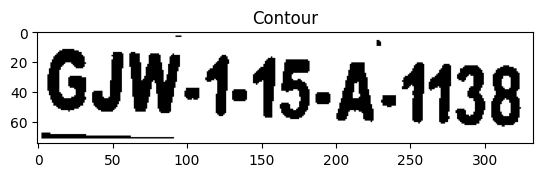

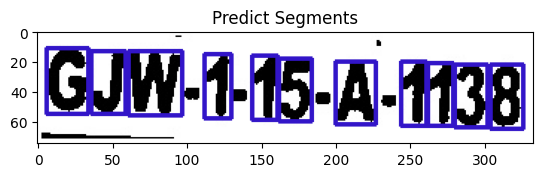

In [15]:
char=segment_characters(cropped)

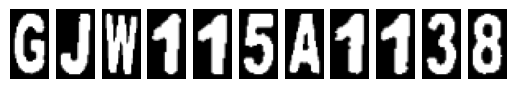

In [16]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Reconocimiento de caracteres usando CNN
Deben entrenar una CNN para reconocer los caracteres en la carpeta `data`

## Predecir el número de matrícula

Con la red ya entrenada, deben predecir el numero de la matricula, alimentando los caracteres ya segementados